<a href="https://colab.research.google.com/github/ah20776/CE807/blob/main/Lab4/CE807_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
!git clone https://github.com/ah20776/CE807.git

fatal: destination path 'CE807' already exists and is not an empty directory.


In [2]:
from smart_open import smart_open
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from nltk.corpus import stopwords
nltk.download('punkt')

%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
df = pd.read_csv('/content/CE807/Lab4/data/tagged_plots_movielens.csv')
df = df.dropna()
df['plot'].apply(lambda x: len(x.split(' '))).sum()

171156

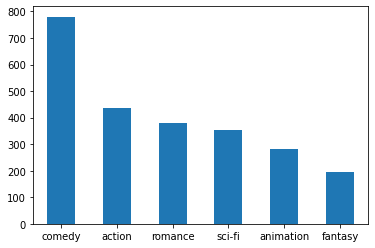

In [5]:
my_tags = ['sci-fi' , 'action', 'comedy', 'fantasy', 'animation', 'romance']
df.tag.value_counts().plot(kind="bar", rot=0)

In [6]:
df

,Unnamed: 0,movieId,plot,tag
0,0,1,A little boy named Andy loves to be in his roo...,animation
1,1,2,When two kids find and play a magical board ga...,fantasy
2,2,3,Things don't seem to change much in Wabasha Co...,comedy
3,3,6,Hunters and their prey--Neil and his professio...,action
4,4,7,An ugly duckling having undergone a remarkable...,romance
...,...,...,...,...
2443,2443,148618,Three kids who travel back in time to 65 milli...,animation
2444,2444,148624,"Top Cat and the gang face a new police chief, ...",animation
2445,2445,149088,Raggedy Ann and the rest of the toys in Marcel...,animation
2446,2446,149406,"Continuing his ""legendary adventures of awesom...",comedy


In [7]:
def print_plot(index):
    example = df[df.index == index][['plot', 'tag']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Genre:', example[1])

In [8]:
print_plot(4)

An ugly duckling having undergone a remarkable change, still harbors feelings for her crush: a carefree playboy, but not before his business-focused brother has something to say about it.
Genre: romance


In [9]:
print_plot(1000)

Now back in San Francisco after their holiday in New York, Nick and Nora find themselves trying to solve another mystery. It's New Year's Eve and they are summoned to dinner at Nora's elderly, and very aristocratic, family. There they find that cousin Selma's husband Robert has been missing for three days. Nick reluctantly agrees to look for him but the case takes a twist when Robert is shot and Selma is accused of murder. Several other murders occur but eventually Nick gathers everyone into the same room to reveal the identity of the killer.
Genre: comedy


In [10]:
train_data, test_data = train_test_split(df, test_size=0.1, random_state=42)
len(test_data)

243

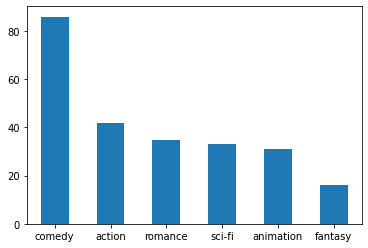

In [11]:
test_data.tag.value_counts().plot(kind="bar", rot=0)

In [12]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(my_tags))
    target_names = my_tags
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [13]:
def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

In [14]:
def predict(vectorizer, classifier, data):
    data_features = vectorizer.transform(data['plot'])
    predictions = classifier.predict(data_features)
    target = data['tag']
    evaluate_prediction(predictions, target)

In [18]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [19]:
%%time
# training
count_vectorizer = CountVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=3000) 
train_data_features = count_vectorizer.fit_transform(train_data['plot'])

CPU times: user 1.39 s, sys: 3.2 ms, total: 1.39 s
Wall time: 1.4 s


In [20]:
%time

logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(train_data_features, train_data['tag'])

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.58 µs


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [21]:
count_vectorizer.get_feature_names()[80:90]

['adventurous',
 'advice',
 'affair',
 'affairs',
 'afraid',
 'africa',
 'african',
 'aftermath',
 'age',
 'aged']

accuracy 0.4444444444444444
confusion matrix
 [[23  1 11  0  4  3]
 [ 4 10 10  0  3  4]
 [12  8 50  2 14  0]
 [ 4  3  2  3  4  0]
 [ 1  3 17  1 10  3]
 [ 9  5  5  2  0 12]]
(row=expected, col=predicted)
CPU times: user 226 ms, sys: 6.85 ms, total: 233 ms
Wall time: 238 ms


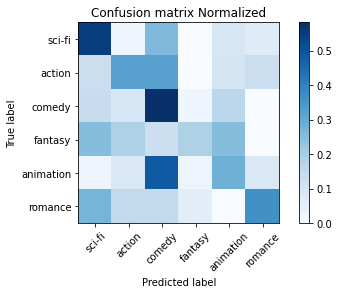

In [22]:
%%time

predict(count_vectorizer, logreg, test_data)

In [24]:
def most_influential_words(vectorizer, genre_index=0, num_words=10):
    features = vectorizer.get_feature_names()
    max_coef = sorted(enumerate(logreg.coef_[genre_index]), key=lambda x:x[1], reverse=True)
    return [features[x[0]] for x in max_coef[:num_words]] 

In [25]:
# words for the fantasy genre
genre_tag_id = 1
print(my_tags[genre_tag_id])
most_influential_words(count_vectorizer, genre_tag_id)

action


['tale',
 'animated',
 'forest',
 'animals',
 'adventurous',
 'anna',
 'snow',
 'victor',
 'halloween',
 'mouse']

In [26]:
train_data_features[0]

<1x3000 sparse matrix of type '<class 'numpy.int64'>'
	with 43 stored elements in Compressed Sparse Row format>

In [27]:
%%time
n_gram_vectorizer = CountVectorizer(
    analyzer="char",
    ngram_range=([2,5]),
    tokenizer=None,    
    preprocessor=None,                               
    max_features=3000) 

logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)

train_data_features = n_gram_vectorizer.fit_transform(train_data['plot'])

logreg = logreg.fit(train_data_features, train_data['tag'])

CPU times: user 8.36 s, sys: 5.32 s, total: 13.7 s
Wall time: 8.78 s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [28]:
n_gram_vectorizer.get_feature_names()[50:60]

[' are ',
 ' as',
 ' as ',
 ' as a',
 ' as t',
 ' ass',
 ' at',
 ' at ',
 ' at t',
 ' att']

accuracy 0.43209876543209874
confusion matrix
 [[20  2 11  1  4  4]
 [ 4  7  9  4  2  5]
 [11  9 43  4 16  3]
 [ 2  3  3  4  2  2]
 [ 6  1 11  1 14  2]
 [ 3  2  7  4  0 17]]
(row=expected, col=predicted)


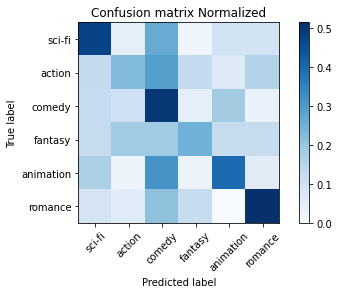

In [29]:
predict(n_gram_vectorizer, logreg, test_data)

In [37]:
%%time
tf_vect = TfidfVectorizer(
    min_df=2, tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english')
train_data_features = tf_vect.fit_transform(train_data['plot'])

logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(train_data_features, train_data['tag'])

CPU times: user 2.75 s, sys: 1.66 s, total: 4.41 s
Wall time: 2.94 s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [38]:
tf_vect.get_feature_names()[1000:1010]

['caesar',
 'cage',
 'caine',
 'cal',
 'calhoun',
 'california',
 'californians',
 'called',
 'calling',
 'callous']

accuracy 0.4773662551440329
confusion matrix
 [[24  1 13  1  1  2]
 [ 4 10  9  2  4  2]
 [ 7  6 53  0 19  1]
 [ 5  5  2  3  0  1]
 [ 1  1 21  0 10  2]
 [ 8  2  5  2  0 16]]
(row=expected, col=predicted)


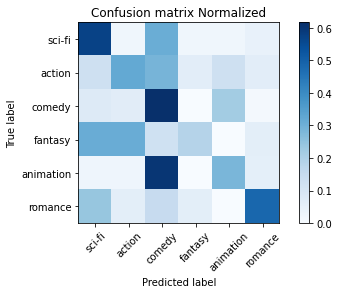

In [39]:
predict(tf_vect, logreg, test_data)

In [40]:
most_influential_words(tf_vect, 1)

['animated',
 'halloween',
 'forest',
 'tale',
 'animals',
 'adventurous',
 'anna',
 'order',
 'taken',
 'dog']

In [41]:
%%time


from gensim.scripts.glove2word2vec import glove2word2vec
import os
glove2word2vec(glove_input_file="data\\vectors.50.txt", word2vec_output_file="data\gensim_glove_vectors.txt")
wv = gensim.models.KeyedVectors.load_word2vec_format( "data\gensim_glove_vectors.txt", binary=False)
os.remove('data\gensim_glove_vectors.txt')
wv.init_sims(replace=True)

FileNotFoundError: ignored